In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set display options for better visibility
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

In [2]:
# Read the CSV file
# Replace 'stock_data.csv' with your actual file path


def read_stock_data(
    file_path="./host_stock_data/AAPL_historical_data_1y.csv",
):
    try:
        # Try reading the file directly
        df = pd.read_csv(file_path)
    except (FileNotFoundError, pd.errors.EmptyDataError, pd.errors.ParserError) as e:
        # If there's an issue with the file path or data format, print a message
        print(f"Error reading file: {str(e)}")
        return None

    return df


# Load the data
df = read_stock_data()

# If data couldn't be loaded, exit the program
if df is None:
    print("Exiting due to data loading error.")
else:
    # Display the first few rows to verify loaded correctly
    print("Initial data:")
    print(df.head())

    # Check for missing values
    print("\nMissing values in each column:")
    print(df.isna().sum())

    # Data shape
    print(f"\nDataset shape: {df.shape}")

Initial data:
         Date    Open    High     Low   Close  Adj_Close      Volume
0  2025-05-14  212.43  213.94  210.58  211.70     211.70  25248451.0
1  2025-05-13  210.43  213.40  209.00  212.93     212.93  51759900.0
2  2025-05-12     NaN     NaN     NaN     NaN        NaN         NaN
3  2025-05-12  210.97  211.27  206.75  210.79     210.79  63775800.0
4  2025-05-09  199.00  200.54  197.54  198.53     198.27  36453900.0

Missing values in each column:
Date         228
Open           1
High           1
Low            1
Close          1
Adj_Close      1
Volume         1
dtype: int64

Dataset shape: (252, 7)


In [3]:
# Data Cleaning and Preparation
# This cell cleans the stock data by:
# - Removing dividend rows
# - Converting columns to appropriate data types
# - Handling missing dates
# - Sorting by date


def clean_stock_data(df):
    # Make a copy to avoid modifying the original
    df_clean = df.copy()

    # Identify dividend rows
    dividend_rows = df_clean["Adj_Close"].astype(str).str.contains("Dividend", na=False)

    # Remove dividend rows
    df_clean = df_clean[~dividend_rows]

    # Convert columns to numeric
    numeric_cols = ["Open", "High", "Low", "Close", "Adj_Close", "Volume"]
    for col in numeric_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

    # Convert Date to datetime
    df_clean["Date"] = pd.to_datetime(df_clean["Date"], errors="coerce")

    # Count missing dates
    missing_dates_count = df_clean["Date"].isna().sum()
    print(f"Number of rows with missing dates: {missing_dates_count}")

    # Fill in missing dates
    if missing_dates_count > 0:
        # Get all dates with data
        valid_dates = df_clean[df_clean["Date"].notna()].copy()
        date_range = sorted(valid_dates["Date"].unique())

        # Create complete business day range
        min_date = min(date_range)
        max_date = max(date_range)
        all_business_days = pd.date_range(start=min_date, end=max_date, freq="B")

        # Find missing business days
        existing_dates = set(date_range)
        available_dates = [
            date for date in all_business_days if date not in existing_dates
        ]
        available_dates = sorted(available_dates, reverse=True)  # Sort newest first

        # Fill in missing dates
        missing_date_rows = df_clean[df_clean["Date"].isna()]
        for idx, row in missing_date_rows.iterrows():
            if available_dates:
                next_date = available_dates.pop(0)
                df_clean.at[idx, "Date"] = next_date

    # Sort by date
    df_clean = df_clean.sort_values("Date", ascending=False)
    df_clean = df_clean.reset_index(drop=True)

    # Remove rows where all numeric columns are NaN
    df_clean = df_clean.dropna(subset=numeric_cols, how="all")

    return df_clean


# Clean the data
df_clean = clean_stock_data(df)

# Display the cleaned data
print("\nCleaned data:")
print(df_clean.head())

Number of rows with missing dates: 228

Cleaned data:
        Date    Open    High     Low   Close  Adj_Close      Volume
0 2025-05-14  212.43  213.94  210.58  211.70     211.70  25248451.0
1 2025-05-13  210.43  213.40  209.00  212.93     212.93  51759900.0
3 2025-05-12  210.97  211.27  206.75  210.79     210.79  63775800.0
4 2025-05-09  199.00  200.54  197.54  198.53     198.27  36453900.0
5 2025-05-08  197.72  200.05  194.68  197.49     197.23  50478900.0


In [4]:
# Basic Exploratory Data Analysis (EDA)
# This cell performs statistical analysis on the cleaned data and handles any remaining missing values
# through linear interpolation for numerical columns like Open, High, Low, Close, Adj_Close, and Volume


def perform_basic_eda(df):
    # Statistical summary
    print("Statistical Summary:")
    print(df.describe())

    # Check for remaining missing values
    print("\nRemaining missing values:")
    print(df.isna().sum())

    # Fill any remaining missing values
    df_filled = df.copy()
    for col in ["Open", "High", "Low", "Close", "Adj_Close", "Volume"]:
        if df_filled[col].isna().sum() > 0:
            df_filled[col] = df_filled[col].interpolate(method="linear")

    # Return the filled dataframe for further analysis
    return df_filled


# Perform basic EDA
df_filled = perform_basic_eda(df_clean)

Statistical Summary:
                                Date        Open        High        Low       Close   Adj_Close        Volume
count                            251  251.000000  251.000000  251.00000  251.000000  251.000000  2.510000e+02
mean   2024-11-19 05:21:16.494023936  222.460837  225.107450  220.16761  222.850040  222.202709  5.596548e+07
min              2024-05-14 00:00:00  171.950000  188.300000  169.21000  172.420000  172.190000  2.323470e+07
25%              2024-08-24 12:00:00  213.340000  215.905000  210.96000  213.405000  213.070000  3.949305e+07
50%              2024-11-20 00:00:00  224.780000  226.830000  223.04000  225.000000  223.960000  4.801330e+07
75%              2025-02-15 12:00:00  233.210000  234.935000  229.79000  233.110000  232.450000  6.031885e+07
max              2025-05-14 00:00:00  258.190000  260.100000  257.63000  259.020000  258.400000  3.186799e+08
std                              NaN   16.673603   16.106658   16.81893   16.500438   16.511655  3.

/var/folders/4z/jxw2hf2n7ws6y7stm6zbhjy80000gn/T/ipykernel_77321/2649509505.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


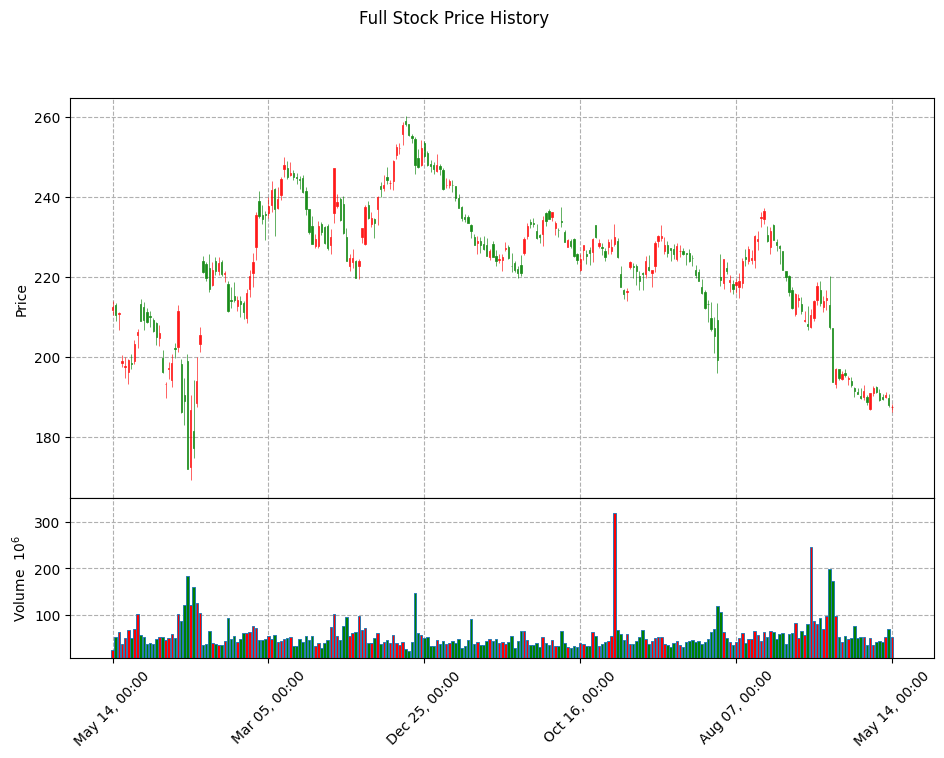

/var/folders/4z/jxw2hf2n7ws6y7stm6zbhjy80000gn/T/ipykernel_77321/2649509505.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


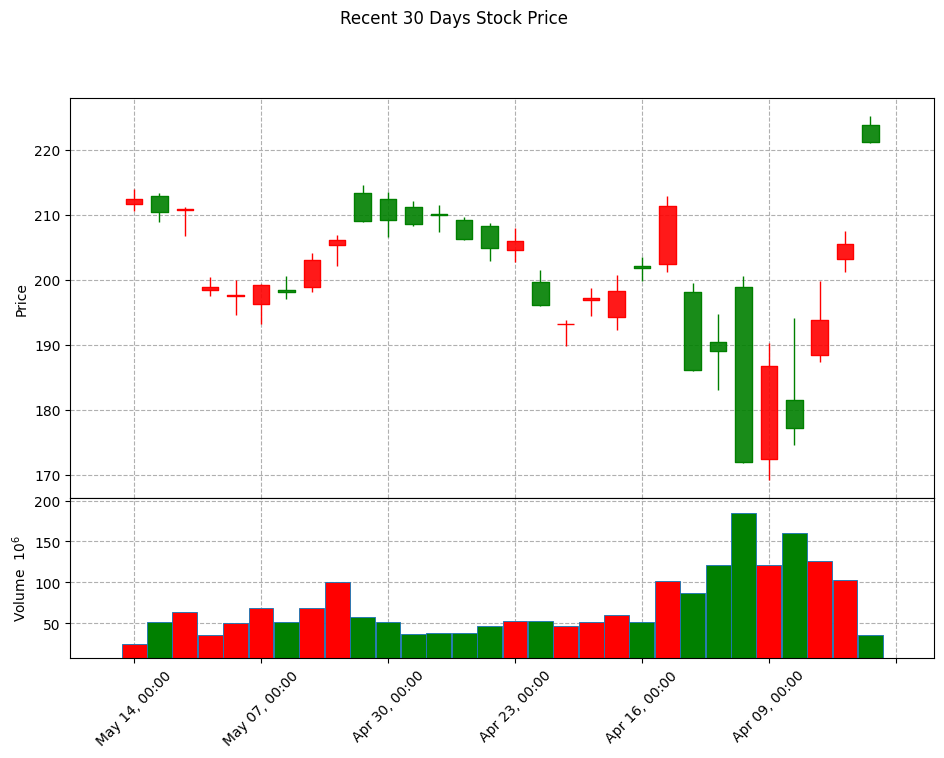

In [5]:
# Candlestick Chart Visualization
# This cell creates candlestick charts to visualize stock price movements over time,
# showing open, high, low, and close prices along with trading volume.
# It generates both a full history chart and a recent 30-day view for more detailed analysis.


def plot_candlestick_chart(df, title="Stock Price Candlestick Chart", days=None):
    # Make a copy and set date as index
    df_plot = df.copy()

    # Limit to specified number of days if provided
    if days is not None and days < len(df_plot):
        df_plot = df_plot.head(days)

    # Make sure date is set as index
    df_plot = df_plot.set_index("Date")

    # Create custom style
    mc = mpf.make_marketcolors(
        up="green", down="red", edge="inherit", wick="inherit", volume="inherit"
    )
    s = mpf.make_mpf_style(marketcolors=mc, gridstyle="--", y_on_right=False)

    # Create figure and add subplot for volume
    fig, axes = mpf.plot(
        df_plot,
        type="candle",
        style=s,
        title=title,
        figsize=(12, 8),
        volume=True,
        returnfig=True,
    )

    plt.tight_layout()
    plt.show()


# Plot full candlestick chart
plot_candlestick_chart(df_filled, title="Full Stock Price History")

# Plot recent data (last 30 days)
plot_candlestick_chart(df_filled, title="Recent 30 Days Stock Price", days=30)

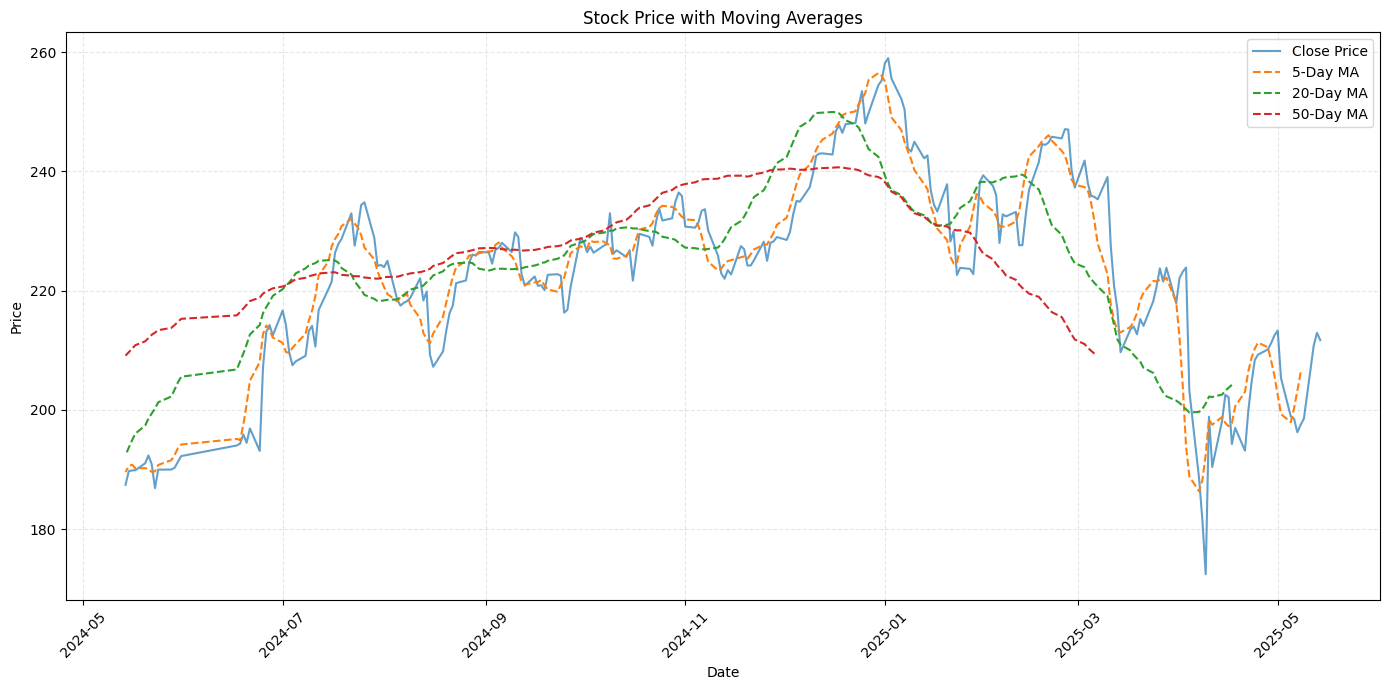

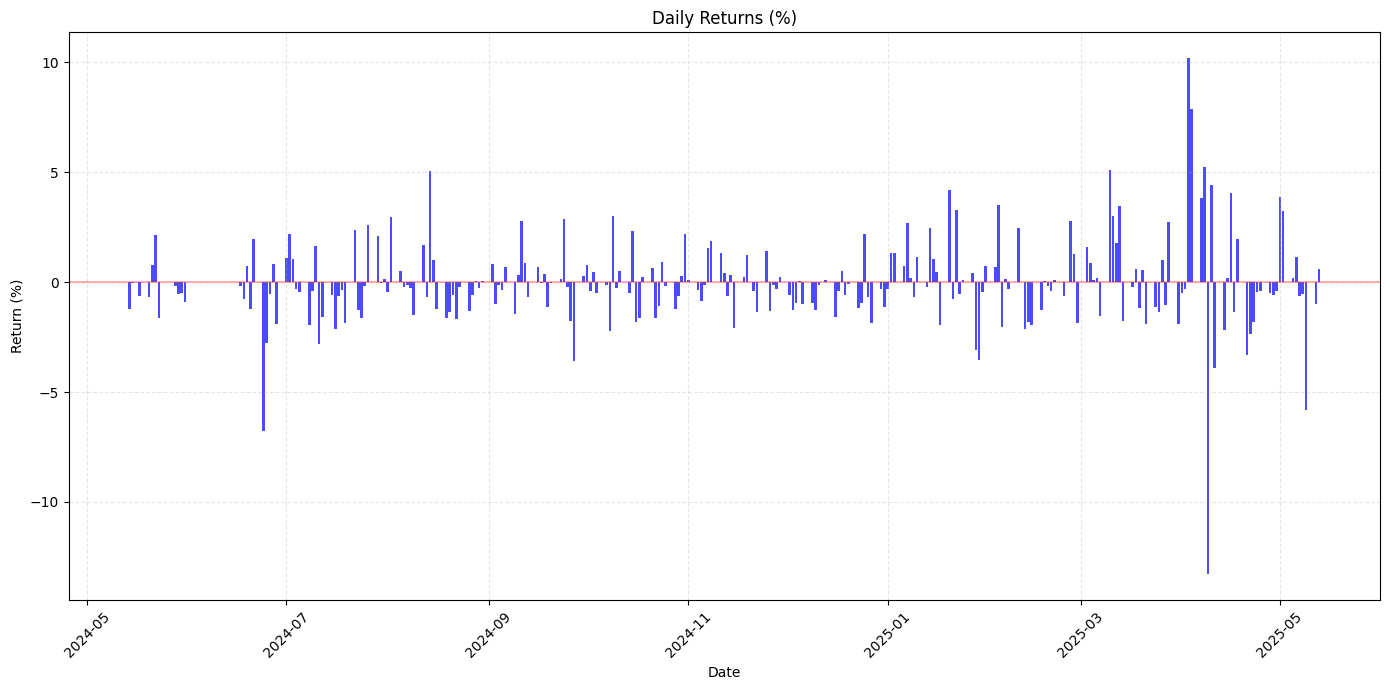

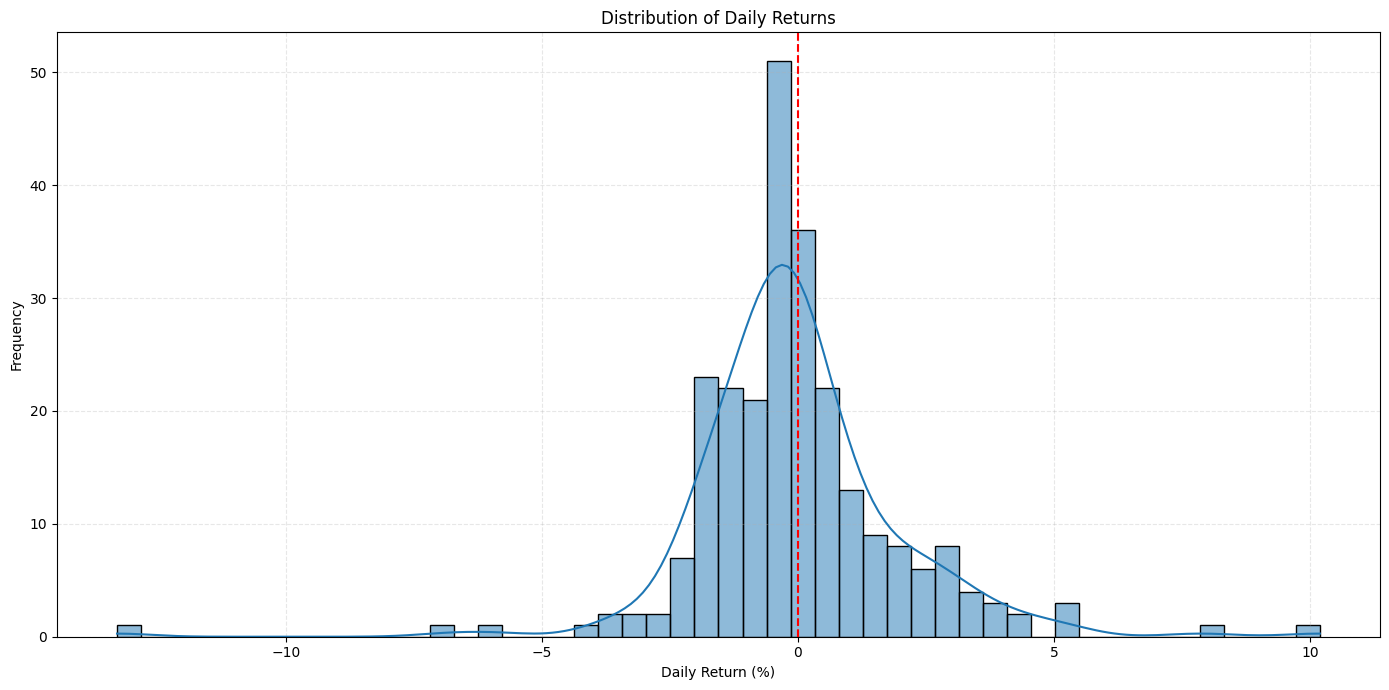

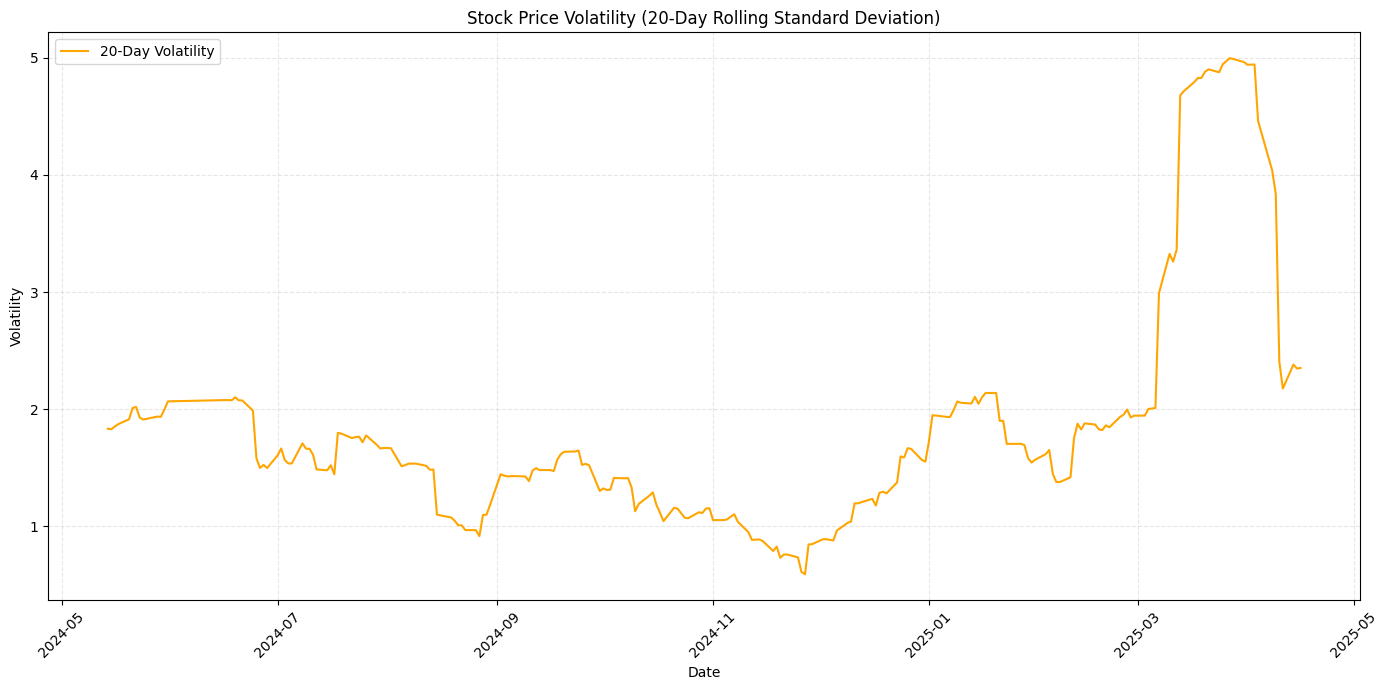

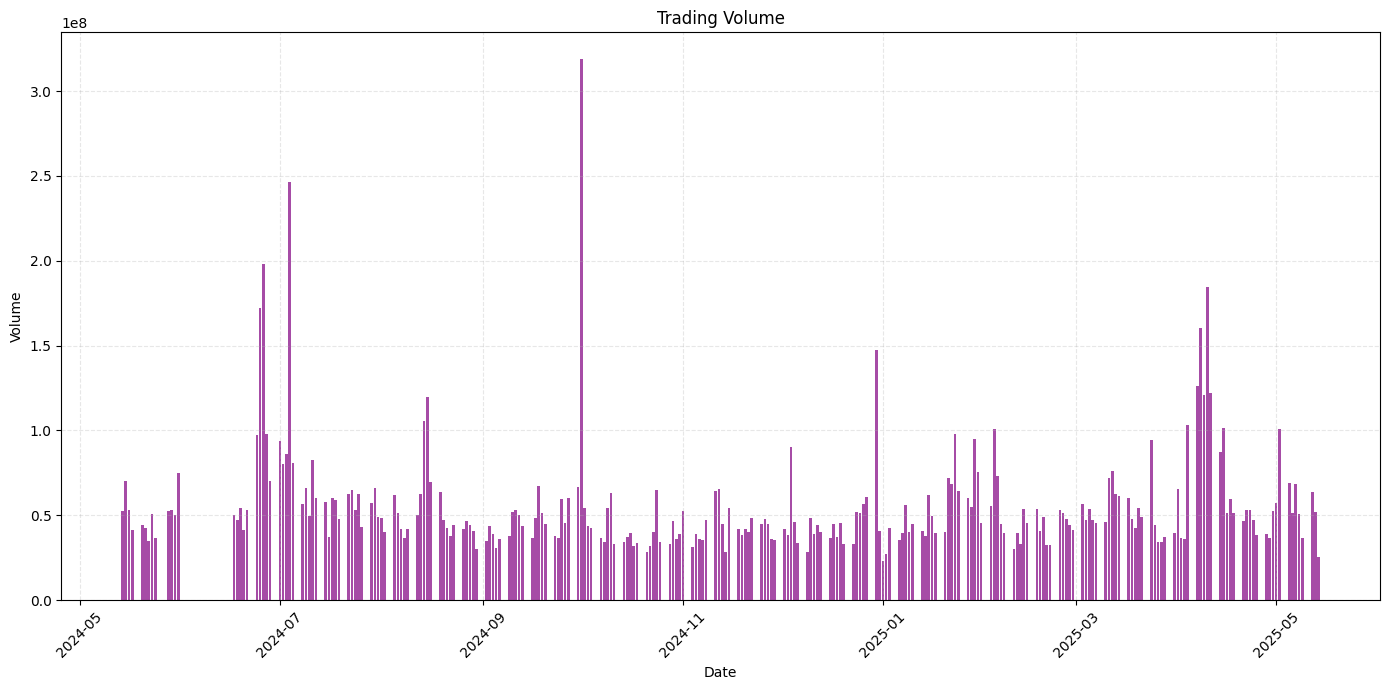

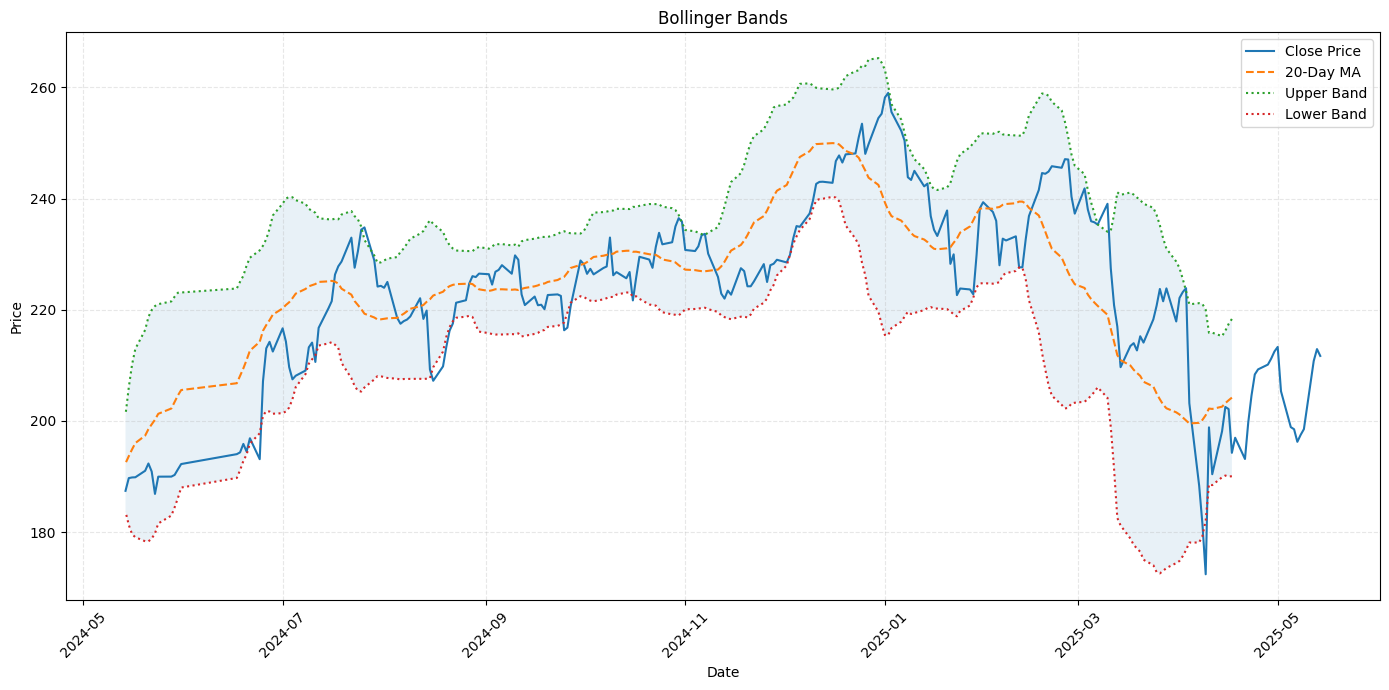

In [6]:
# Advanced Stock Analysis and Visualization
# This cell performs comprehensive technical analysis on stock data, calculating key indicators
# such as moving averages, volatility, and Bollinger Bands. It generates multiple visualizations
# to help understand price trends, daily returns, volatility patterns, volume analysis, and
# technical indicators for better trading decision support.


def perform_advanced_analysis(df):
    # Calculate daily returns
    df["Daily_Return"] = df["Close"].pct_change() * 100

    # Calculate moving averages
    df["MA5"] = df["Close"].rolling(window=5).mean()
    df["MA20"] = df["Close"].rolling(window=20).mean()
    df["MA50"] = df["Close"].rolling(window=50).mean()

    # Calculate volatility (rolling standard deviation)
    df["Volatility"] = df["Daily_Return"].rolling(window=20).std()

    # Plot closing price with moving averages
    plt.figure(figsize=(14, 7))
    plt.plot(df["Date"], df["Close"], label="Close Price", alpha=0.7)
    plt.plot(df["Date"], df["MA5"], label="5-Day MA", linestyle="--")
    plt.plot(df["Date"], df["MA20"], label="20-Day MA", linestyle="--")
    plt.plot(df["Date"], df["MA50"], label="50-Day MA", linestyle="--")
    plt.title("Stock Price with Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot daily returns
    plt.figure(figsize=(14, 7))
    plt.bar(df["Date"], df["Daily_Return"], alpha=0.7, color="blue")
    plt.title("Daily Returns (%)")
    plt.xlabel("Date")
    plt.ylabel("Return (%)")
    plt.axhline(y=0, color="r", linestyle="-", alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot daily returns distribution
    plt.figure(figsize=(14, 7))
    sns.histplot(df["Daily_Return"].dropna(), kde=True, bins=50)
    plt.title("Distribution of Daily Returns")
    plt.xlabel("Daily Return (%)")
    plt.ylabel("Frequency")
    plt.axvline(x=0, color="r", linestyle="--")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot volatility over time
    plt.figure(figsize=(14, 7))
    plt.plot(df["Date"], df["Volatility"], color="orange", label="20-Day Volatility")
    plt.title("Stock Price Volatility (20-Day Rolling Standard Deviation)")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Volume analysis
    plt.figure(figsize=(14, 7))
    plt.bar(df["Date"], df["Volume"], alpha=0.7, color="purple")
    plt.title("Trading Volume")
    plt.xlabel("Date")
    plt.ylabel("Volume")
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Calculate and plot Bollinger Bands
    df["Middle_Band"] = df["Close"].rolling(window=20).mean()
    df["Upper_Band"] = df["Middle_Band"] + (df["Close"].rolling(window=20).std() * 2)
    df["Lower_Band"] = df["Middle_Band"] - (df["Close"].rolling(window=20).std() * 2)

    plt.figure(figsize=(14, 7))
    plt.plot(df["Date"], df["Close"], label="Close Price")
    plt.plot(df["Date"], df["Middle_Band"], label="20-Day MA", linestyle="--")
    plt.plot(df["Date"], df["Upper_Band"], label="Upper Band", linestyle=":")
    plt.plot(df["Date"], df["Lower_Band"], label="Lower Band", linestyle=":")
    plt.fill_between(df["Date"], df["Upper_Band"], df["Lower_Band"], alpha=0.1)
    plt.title("Bollinger Bands")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df


# Perform advanced analysis
df_analysis = perform_advanced_analysis(df_filled)

In [7]:
# Interactive Visualization with Plotly
# This cell creates an interactive candlestick chart with volume and moving averages
# using Plotly, allowing for dynamic exploration of stock data


# Interactive Plotly Candlestick Chart
def interactive_candlestick(df):
    # Create figure
    fig = make_subplots(
        rows=2,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.1,
        subplot_titles=("Price", "Volume"),
        row_heights=[0.7, 0.3],
    )

    # Add candlestick trace
    fig.add_trace(
        go.Candlestick(
            x=df["Date"],
            open=df["Open"],
            high=df["High"],
            low=df["Low"],
            close=df["Close"],
            name="Candlestick",
        ),
        row=1,
        col=1,
    )

    # Add volume trace
    fig.add_trace(
        go.Bar(
            x=df["Date"],
            y=df["Volume"],
            name="Volume",
            marker_color="rgba(0, 0, 255, 0.5)",
        ),
        row=2,
        col=1,
    )

    # Add moving averages
    fig.add_trace(
        go.Scatter(
            x=df["Date"],
            y=df["MA5"],
            name="5-Day MA",
            line=dict(color="purple", width=1),
        ),
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Scatter(
            x=df["Date"],
            y=df["MA20"],
            name="20-Day MA",
            line=dict(color="orange", width=1),
        ),
        row=1,
        col=1,
    )

    # Update layout
    fig.update_layout(
        title="Interactive Stock Chart",
        xaxis_title="Date",
        yaxis_title="Price",
        xaxis_rangeslider_visible=False,
        template="plotly_white",
        height=800,
        width=1200,
        showlegend=True,
        hovermode="x unified",
    )

    # Update y-axis for volume subplot
    fig.update_yaxes(title_text="Volume", row=2, col=1)

    # Show figure
    fig.show()


# Create interactive chart
interactive_candlestick(df_analysis)

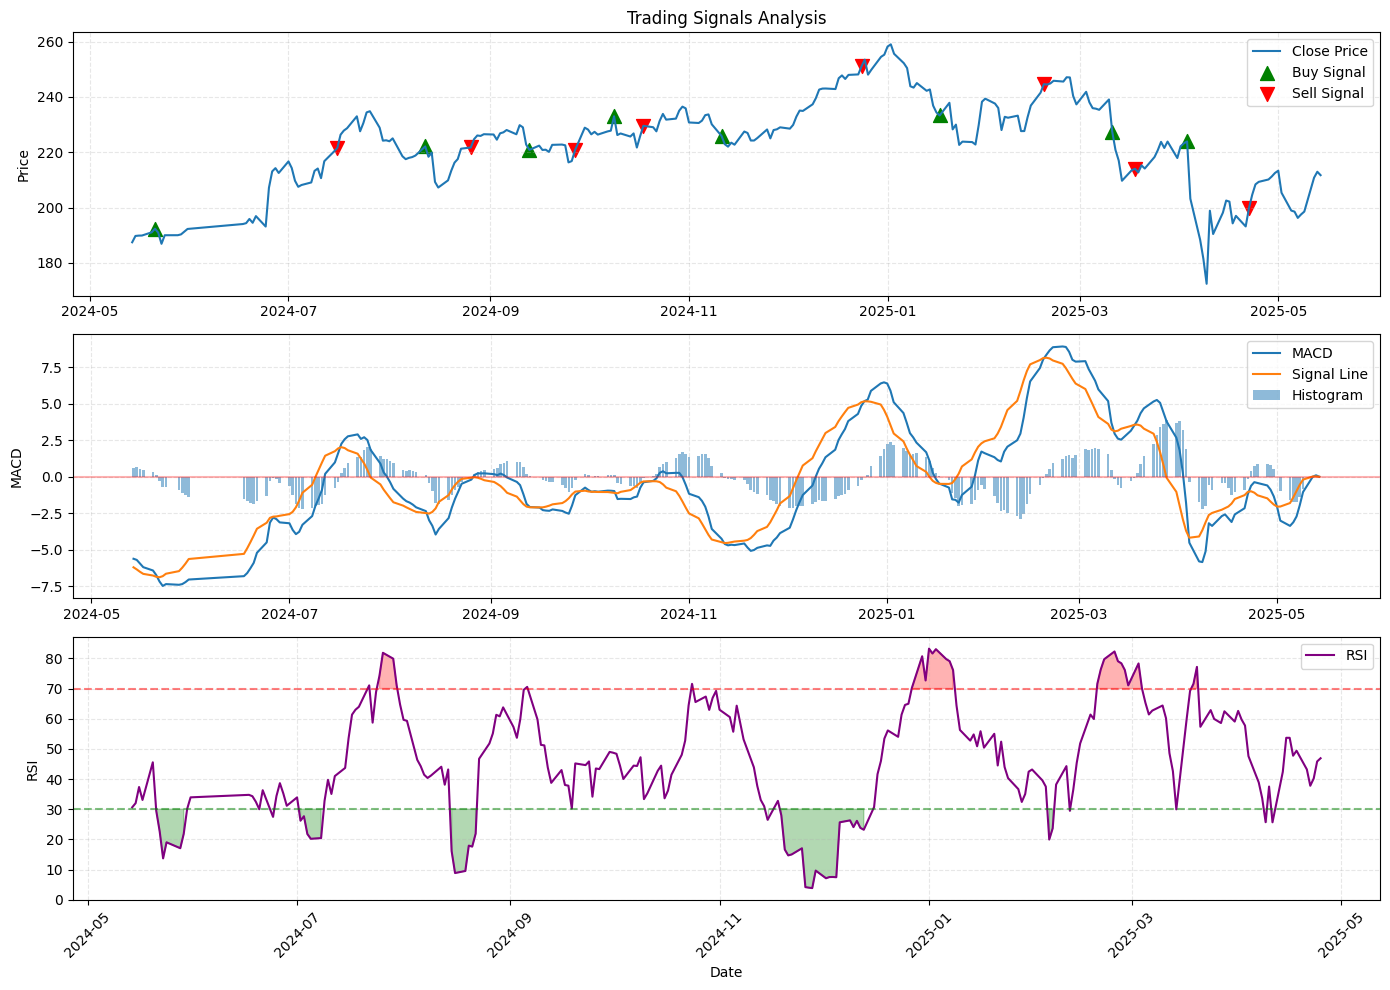

/var/folders/4z/jxw2hf2n7ws6y7stm6zbhjy80000gn/T/ipykernel_77321/1225327130.py:116: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



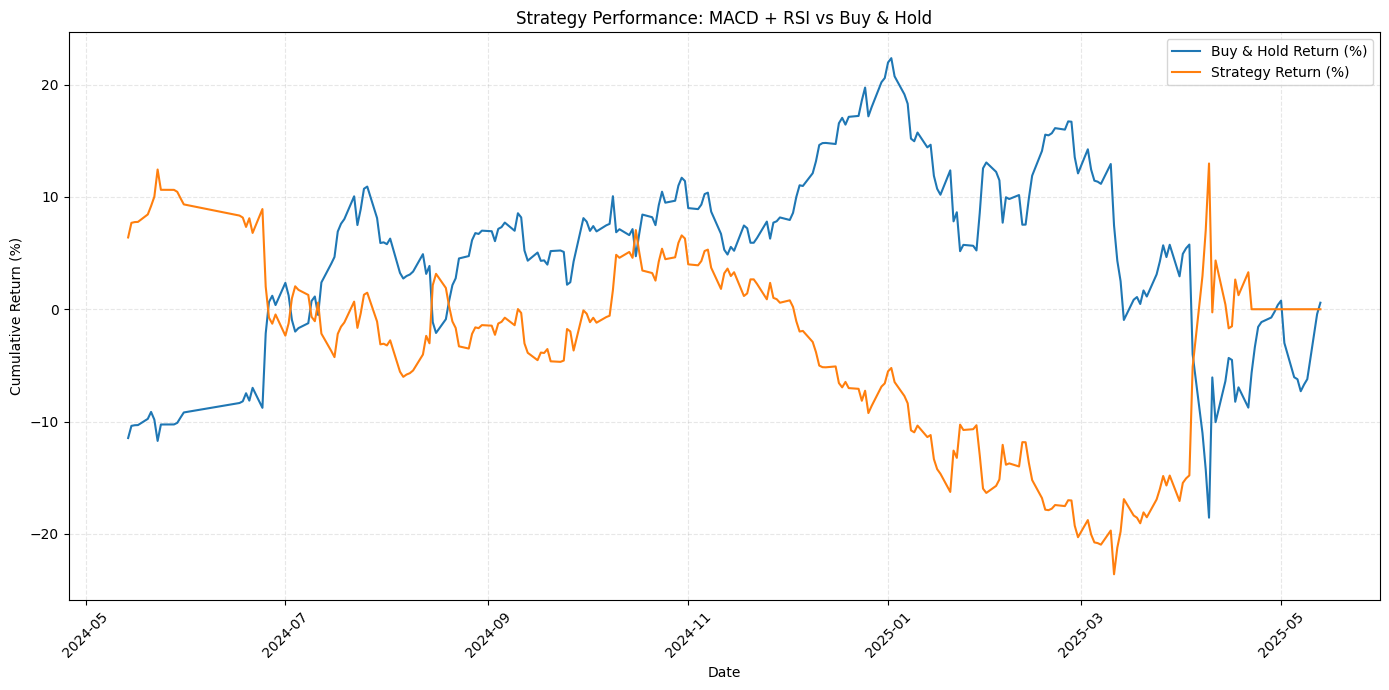

In [8]:
# Trading Signals Analysis and Backtesting
# This cell calculates technical indicators (MACD, RSI), generates trading signals,
# visualizes them on price charts, and performs a simple backtest comparing the
# strategy returns against a buy-and-hold approach.
#
# Strategy Explanation:
# 1. MACD (Moving Average Convergence Divergence) - Tracks the relationship between two moving averages
#    - When MACD crosses above Signal Line: Potential bullish momentum
#    - When MACD crosses below Signal Line: Potential bearish momentum
# 2. RSI (Relative Strength Index) - Measures the speed and change of price movements
#    - RSI > 70: Potentially overbought condition
#    - RSI < 30: Potentially oversold condition
# 3. Combined Strategy Rules:
#    - BUY when: MACD crosses above Signal Line AND RSI < 70 (not overbought)
#    - SELL when: MACD crosses below Signal Line AND RSI > 30 (not oversold)
#    - This aims to capture momentum while avoiding entering at extreme market conditions


def analyze_trading_signals(df):
    # Calculate MACD
    df["EMA12"] = df["Close"].ewm(span=12, adjust=False).mean()
    df["EMA26"] = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD"] = df["EMA12"] - df["EMA26"]
    df["Signal_Line"] = df["MACD"].ewm(span=9, adjust=False).mean()
    df["MACD_Histogram"] = df["MACD"] - df["Signal_Line"]

    # Calculate RSI
    delta = df["Close"].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()

    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))

    # Generate simple trading signals
    # Buy when MACD crosses above Signal Line and RSI < 70
    # Sell when MACD crosses below Signal Line and RSI > 30
    df["MACD_Signal"] = np.where(
        (df["MACD"] > df["Signal_Line"])
        & (df["MACD"].shift(1) <= df["Signal_Line"].shift(1))
        & (df["RSI"] < 70),
        1,
        0,
    )  # 1 for buy

    df["MACD_Signal"] = np.where(
        (df["MACD"] < df["Signal_Line"])
        & (df["MACD"].shift(1) >= df["Signal_Line"].shift(1))
        & (df["RSI"] > 30),
        -1,
        df["MACD_Signal"],
    )  # -1 for sell

    # Plot MACD with buy/sell signals
    plt.figure(figsize=(14, 10))

    # Price and signals subplot
    plt.subplot(3, 1, 1)
    plt.plot(df["Date"], df["Close"], label="Close Price")
    plt.scatter(
        df.loc[df["MACD_Signal"] == 1, "Date"],
        df.loc[df["MACD_Signal"] == 1, "Close"],
        color="green",
        label="Buy Signal",
        marker="^",
        s=100,
    )
    plt.scatter(
        df.loc[df["MACD_Signal"] == -1, "Date"],
        df.loc[df["MACD_Signal"] == -1, "Close"],
        color="red",
        label="Sell Signal",
        marker="v",
        s=100,
    )
    plt.title("Trading Signals Analysis")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # MACD subplot
    plt.subplot(3, 1, 2)
    plt.plot(df["Date"], df["MACD"], label="MACD")
    plt.plot(df["Date"], df["Signal_Line"], label="Signal Line")
    plt.bar(df["Date"], df["MACD_Histogram"], alpha=0.5, label="Histogram")
    plt.axhline(y=0, color="r", linestyle="-", alpha=0.3)
    plt.ylabel("MACD")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # RSI subplot
    plt.subplot(3, 1, 3)
    plt.plot(df["Date"], df["RSI"], label="RSI", color="purple")
    plt.axhline(y=70, color="r", linestyle="--", alpha=0.5)
    plt.axhline(y=30, color="g", linestyle="--", alpha=0.5)
    plt.fill_between(
        df["Date"], df["RSI"], 70, where=(df["RSI"] >= 70), color="red", alpha=0.3
    )
    plt.fill_between(
        df["Date"], df["RSI"], 30, where=(df["RSI"] <= 30), color="green", alpha=0.3
    )
    plt.xlabel("Date")
    plt.ylabel("RSI")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Backtest simple strategy
    df["Position"] = (
        df["MACD_Signal"].replace(0, np.nan).fillna(method="ffill").fillna(0)
    )
    df["Strategy_Return"] = df["Position"].shift(1) * df["Daily_Return"]

    # Calculate cumulative returns
    df["Cumulative_Market_Return"] = (1 + df["Daily_Return"] / 100).cumprod() - 1
    df["Cumulative_Strategy_Return"] = (1 + df["Strategy_Return"] / 100).cumprod() - 1

    # Plot strategy vs market returns
    plt.figure(figsize=(14, 7))
    plt.plot(
        df["Date"], df["Cumulative_Market_Return"] * 100, label="Buy & Hold Return (%)"
    )
    plt.plot(
        df["Date"], df["Cumulative_Strategy_Return"] * 100, label="Strategy Return (%)"
    )
    plt.title("Strategy Performance: MACD + RSI vs Buy & Hold")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return df


# Analyze trading signals
df_signals = analyze_trading_signals(df_analysis)